# LSTM model for Emotion Detection on labeled CMU Panoptic dataset
The LSTM model has 30 states in this script, corresponding to the 30 frames within one second.

## Input
trainX : 3-d array with shape: (# of seconds in total, # of frames/states, dimension of features)

e.g. in office1 should be (5346,30,76)

trainy : 1-d array with shape: (# of seconds in total,1)

## Output

Evaluation metrics and runtime spent on fitting

## Multipule persons
Notice, the LSTM model here is only for single person. 
The task for multiple person detection is conducted by openpose.

So, in the training stage, even if there are multiple persons in one sequence, we split them apart and train the LSTM respectively. 
Different persons' skeletons are a kind of data augmentation here.

While in the demo stage, we will assign each person emerging in the camera one LSTM. 

## Questions left
Why there are 2 persons in office2? Person 2's frames count is 1211?

In [7]:

import os
import json
from time import time
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.models import model_from_json
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt

## Function for preparing the X and y for LSTM training and validation

In [8]:
'''
### X 
type: np.ndarray
shape: (# of samples, fps, 76)

### y 
type: list
shape: (# of samples,1)

The calibrated skeletons for each person are stored in :
../170915_office1/camerawise_skeleton/hd_0_0(0-30)_samples_for_persons.json

'''
def prepare_X_y(label_name,data_path,seq_name):
    

    # Load the skeletons from different cameras
    cameras_skeletons_list=list()
    json_files = [pos_json for pos_json in os.listdir(data_path+seq_name+"/camerawise_skeleton/") if pos_json.endswith('.json')]

    for index, js in enumerate(json_files):
        try:
            with open(os.path.join(data_path+seq_name+"/camerawise_skeleton/", js)) as json_file:
                skeletons = json.load(json_file)
            cameras_skeletons_list.append(skeletons)
        except IOError as e:
            print('Error reading {0}\n'.format(skel_json_fname)+e.strerror) 
    
#     print("# of cameras:",len(cameras_skeletons_list))
    
    # Load the labels
    df = pd.read_excel (data_path+seq_name+label_name)
    labels=df.as_matrix()# (68,2) ndarray
    threshold=34
    # threshold deal with no big enough # of skeletons frames
    # threshold=argmax(seconds[i]<floor(len(skeletons)/fps)-1)
    if label_name=='/office1_label.xlsx':
        threshold=63
    else:
#         threshold=34
        threshold=14
        
    seconds=list(labels[:,0])[0:threshold]# extract all the useful seconds
    emotion_label=labels[:,1][0:threshold]# extract all the useful labels

    # Convert the seconds into the frame indexes, the transform equation is: frames=30*seconds + frame
    frames_indices=list()
    for second in seconds:
        for inner_second_frame in range(fps):
            frames_indices.append(fps*second+inner_second_frame)

    # Filter the seconds(samples) that only appear in the labels
    person_trainX=dict()
    for skeletons in cameras_skeletons_list:
        for person, skels in skeletons.items():
            filtered_skels=list()
            for i in range(len(skels)):
                if i in frames_indices:
                    filtered_skels.append(skels[i])
            if person not in person_trainX.keys():
                person_trainX[person]=list()
                
                person_trainX[person].extend(filtered_skels)
            else:
                person_trainX[person].extend(filtered_skels)

    # Convert the skeletons list into ndarray         
    for person, samples in person_trainX.items():
        # person_trainX[person] store the X
        if person=='0':
            person_trainX[person]=np.array(person_trainX[person]).reshape((-1,fps,76))

    # Extend emotion labels for 31 cameras 
    y_list=list()
    [y_list.extend(emotion_label) for i in range(31)]



    # Get the X and y for next step
    X=person_trainX['0']
#     y=to_categorical(np.array(y_list))# keras one-hot classification label vector
    
    return X,y_list


## Function for 10-fold Cross-Validation for LSTM
**1)** We will define the model as having a single LSTM hidden layer.

LSTM(hidden_nodes, input_shape=(timesteps, input_dim))

hidden_nodes = This is the number of neurons of the LSTM. 
If you have a higher number, the network gets more powerful. 
Howevery, the number of parameters to learn also rises. 
This means it needs more time to train the network.

timesteps = the number of timesteps you want to consider. 
E.g. if you want to classify a sentence, this would be the number of words in a sentence.

input_dim = the dimensions of your features/embeddings. 
E.g. a vector representation of the words in the sentence

**2)** This is followed by a dropout layer intended to reduce overfitting of the model to the training data.

**3)** Finally, a dense fully connected layer is used to interpret the features extracted by the LSTM hidden layer, before a final output layer is used to make predictions.

**4)** The efficient Adam version of stochastic gradient descent will be used to optimize the network, and the categorical cross entropy loss function will be used given that we are learning a multi-class classification problem.

In [111]:
def LSTM_cv(folds,verbose, epochs, batch_size,X,y_list,y):    
    print("Start Cross Validation")
    # Define 10-fold cross validation test harness
    seed=7
    kfold = StratifiedKFold(folds, shuffle=True, random_state=seed)
    cvscores = []
    cvtime=[]
    n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
    cv=1
    show_model = True
    # 10 Fold CV for LSTM
#     print(X.shape)
#     print("Start kfold")
    for train, test in kfold.split(X, y_list):    
        # LSTM model
        # The output for the model will be a three-element vector containing the probability of a given second belonging to each of the three emotion types.
        model = Sequential()
        model.add(CuDNNLSTM(78, 
                       return_sequences=True, 
                       input_shape=(n_timesteps,n_features)))
#         model.add(Dropout(0.2))
#         model.add(CuDNNLSTM(50, return_sequences=True))
        model.add(Dropout(0.08))
        model.add(CuDNNLSTM(58, return_sequences=True))
        model.add(Dropout(0.08))
        model.add(CuDNNLSTM(58))
        model.add(Dropout(0.08))
        model.add(Dense(58, activation='relu'))
        model.add(Dense(28, activation='relu'))
        model.add(Dense(8, activation='relu'))

        model.add(Dense(n_outputs, activation='softmax'))
        optimizer=Adam(lr=8e-5)
#         optimizer=Adam(lr=0.00000888, beta_1=0.9, beta_2=0.999, amsgrad=False)
#         optimizer=SGD(lr=0.00588)
        if show_model:
            print(model.summary())
            show_model = False
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#         print("compiled the model")
        # fit network
        t0 = time()
        print("started fitting")
        history=model.fit(X[train], to_categorical(np.array(y_list)[train]),validation_split=0.33, epochs=epochs, batch_size=batch_size, verbose=verbose)
#         print("finished fitting")
        t1 = time()
        
#         print("started eval")
        # evaluate model
        scores = model.evaluate(X[test], to_categorical(np.array(y_list)[test]), batch_size=batch_size, verbose=verbose)
#         print("finished eval")
        
        # list all data in history
        print(history.history.keys())
        # summarize history for accuracy
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        plt.savefig('results/accuracy/model_accuracy_'+str(epochs)+'epochs_'+str(cv)+'cv.png')
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        plt.savefig('results/loss/model_loss_'+str(epochs)+'epochs_'+str(cv)+'cv.png')
        
        
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))# model.metrics_names only have loss and acc
        cvscores.append(scores[1] * 100)
        cvtime.append(t1-t0)
        cv+=1
    return cvscores,cvtime


In [112]:
# Setup the paths
data_path = '../'
seq_name_1 = '170915_office1'#5376 samples in total
seq_name_2 = '170407_office2' #3649
label_name_office1= '/office1_label.xlsx'
label_name_office2= '/office2_label.xlsx'

camera_name='0' #could be 0-30
# hd_skel_json_path=data_path+seq_name+"/camerawise_skeleton/"
fps=30

In [113]:
# # Read the datasets from office1 and office2 
# X1,y1_list=prepare_X_y(label_name_office1,data_path,seq_name_1)
# X2,y2_list=prepare_X_y(label_name_office2,data_path,seq_name_2)

# # Conbine office1 and office2
# X=np.concatenate((X1, X2), axis=0)
# y1_list.extend(y2_list)
# y=to_categorical(np.array(y1_list))# keras one-hot classification label vector

# def convert(o):
#     if isinstance(o, np.int64): return int(o)  
#     raise TypeError
# np.save('X.npy',X)
# np.save('y.npy',y)
# with open('y1_list.json', 'w+') as outfile:
#     json.dump(y1_list, outfile,default=convert)

Start Cross Validation
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_266 (CuDNNLSTM)   (None, 30, 78)            48672     
_________________________________________________________________
dropout_53 (Dropout)         (None, 30, 78)            0         
_________________________________________________________________
cu_dnnlstm_267 (CuDNNLSTM)   (None, 30, 58)            32016     
_________________________________________________________________
dropout_54 (Dropout)         (None, 30, 58)            0         
_________________________________________________________________
cu_dnnlstm_268 (CuDNNLSTM)   (None, 58)                27376     
_________________________________________________________________
dropout_55 (Dropout)         (None, 58)                0         
_________________________________________________________________
dense_341 (Dense)            (

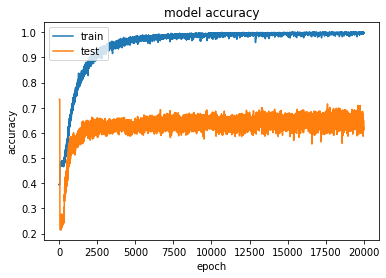

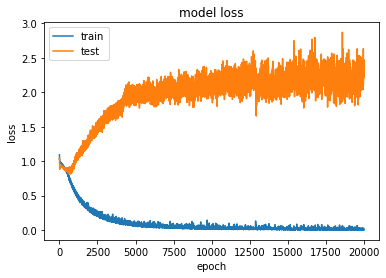

accuracy: 67.78%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


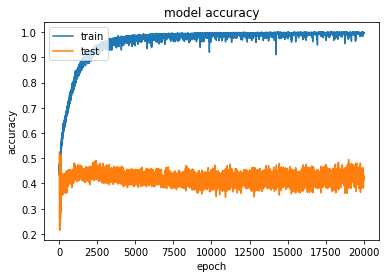

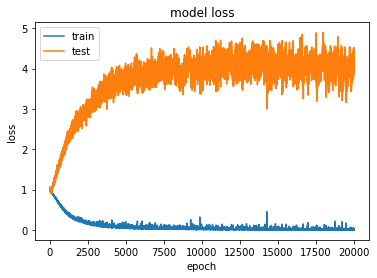

accuracy: 52.72%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


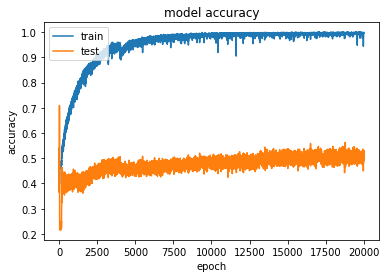

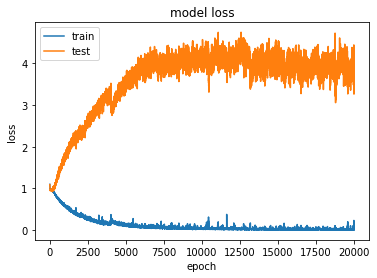

accuracy: 60.25%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


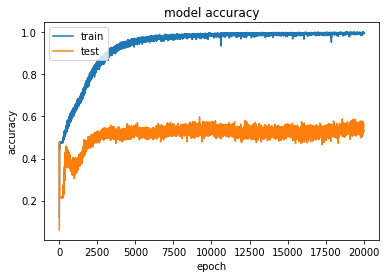

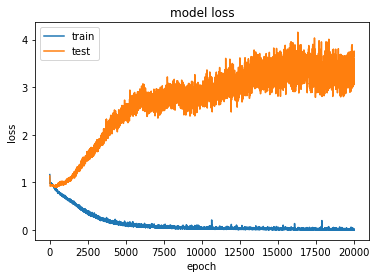

accuracy: 53.97%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


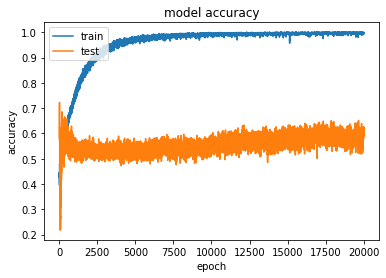

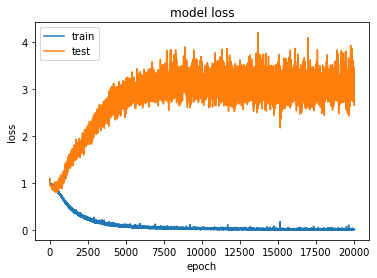

accuracy: 65.27%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


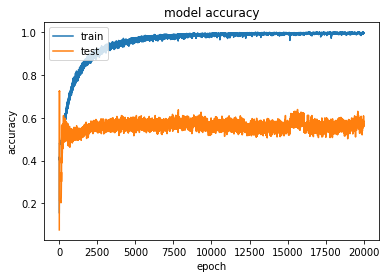

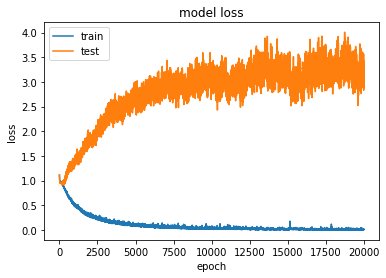

accuracy: 63.60%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


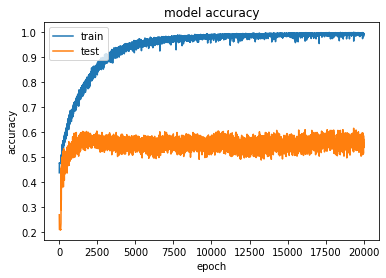

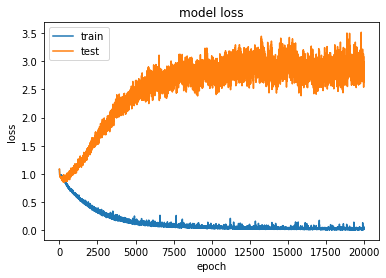

accuracy: 56.90%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


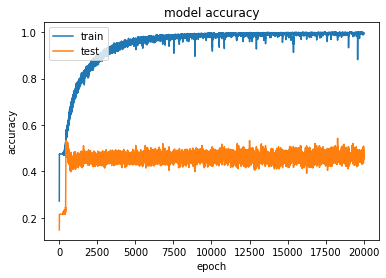

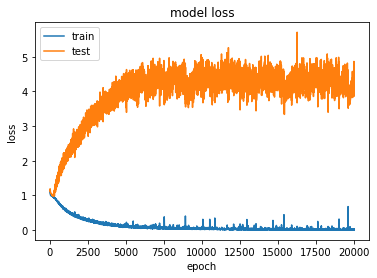

accuracy: 51.05%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


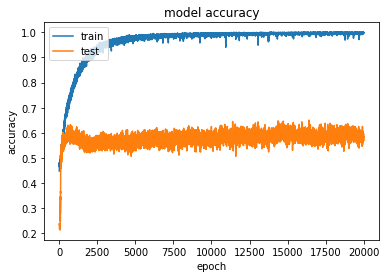

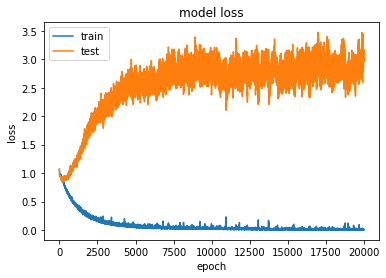

accuracy: 64.29%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


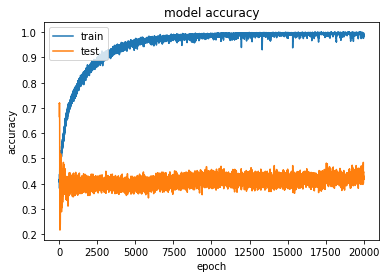

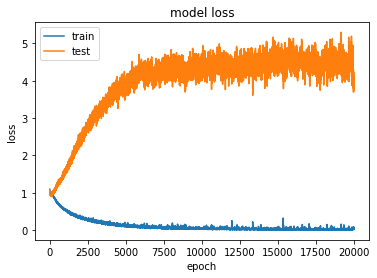

accuracy: 52.74%
58.86% (+/- 5.82%)
average time spent on fitting for each cv with epoch=  20000, batchsize=  500 is:  3346.718869 seconds


<Figure size 432x288 with 0 Axes>

In [114]:
# Load the dataset we want
X=np.load('X.npy')
y=np.load('y.npy')

y1 = np.array([yi[1:] for yi in y])

with open('y1_list.json') as infile:
    y1_list=json.load(infile)
y1_list = np.array(y1_list) - 1

# set_trace()
# Train and evalute the LSTM model using 10-fold cross-validation
folds,verbose, epochs, batch_size=10,0,20000,500
cvscores,cvtime=LSTM_cv(folds,verbose, epochs, batch_size,X,y1_list,y1)

# Print out the result to console
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("average time spent on fitting for each cv with epoch= % d, batchsize= % d is: % 8f seconds" % (epochs,batch_size,np.mean(cvtime)))

# Print out the result to txt
sample = open('results/office1and2_lstm_result.txt', 'w+') 
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)), file = sample) 
print("average time spent on fitting for each cv with epoch= % d, batchsize= % d is: % .8f seconds" % (epochs,batch_size,np.mean(cvtime)), file = sample)
sample.close() 


In [ ]:
%debug


In [115]:
def LSTM_cv(folds,verbose, epochs, batch_size,X,y_list,y):    
    print("Start Cross Validation")
    # Define 10-fold cross validation test harness
    seed=7
    kfold = StratifiedKFold(folds, shuffle=True, random_state=seed)
    cvscores = []
    cvtime=[]
    n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
    cv=1
    show_model = True
    # 10 Fold CV for LSTM
#     print(X.shape)
#     print("Start kfold")
    for train, test in kfold.split(X, y_list):    
        # LSTM model
        # The output for the model will be a three-element vector containing the probability of a given second belonging to each of the three emotion types.
        model = Sequential()
        model.add(CuDNNLSTM(200, 
                       return_sequences=True, 
                       input_shape=(n_timesteps,n_features)))
#         model.add(Dropout(0.2))
#         model.add(CuDNNLSTM(50, return_sequences=True))
        model.add(Dropout(0.08))
        model.add(CuDNNLSTM(100, return_sequences=True))
        model.add(Dropout(0.08))
        model.add(CuDNNLSTM(58))
        model.add(Dropout(0.08))
        model.add(Dense(58, activation='relu'))
        model.add(Dense(28, activation='relu'))
        model.add(Dense(8, activation='relu'))

        model.add(Dense(n_outputs, activation='softmax'))
        optimizer=Adam(lr=8e-5)
#         optimizer=Adam(lr=0.00000888, beta_1=0.9, beta_2=0.999, amsgrad=False)
#         optimizer=SGD(lr=0.00588)
        if show_model:
            print(model.summary())
            show_model = False
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#         print("compiled the model")
        # fit network
        t0 = time()
        print("started fitting")
        history=model.fit(X[train], to_categorical(np.array(y_list)[train]),validation_split=0.33, epochs=epochs, batch_size=batch_size, verbose=verbose)
#         print("finished fitting")
        t1 = time()
        
#         print("started eval")
        # evaluate model
        scores = model.evaluate(X[test], to_categorical(np.array(y_list)[test]), batch_size=batch_size, verbose=verbose)
#         print("finished eval")
        
        # list all data in history
        print(history.history.keys())
        # summarize history for accuracy
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        plt.savefig('results/accuracy/model_accuracy_'+str(epochs)+'epochs_'+str(cv)+'cv.png')
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        plt.savefig('results/loss/model_loss_'+str(epochs)+'epochs_'+str(cv)+'cv.png')
        
        
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))# model.metrics_names only have loss and acc
        cvscores.append(scores[1] * 100)
        cvtime.append(t1-t0)
        cv+=1
    return cvscores,cvtime


Start Cross Validation
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_296 (CuDNNLSTM)   (None, 30, 200)           222400    
_________________________________________________________________
dropout_83 (Dropout)         (None, 30, 200)           0         
_________________________________________________________________
cu_dnnlstm_297 (CuDNNLSTM)   (None, 30, 100)           120800    
_________________________________________________________________
dropout_84 (Dropout)         (None, 30, 100)           0         
_________________________________________________________________
cu_dnnlstm_298 (CuDNNLSTM)   (None, 58)                37120     
_________________________________________________________________
dropout_85 (Dropout)         (None, 58)                0         
_________________________________________________________________
dense_381 (Dense)            (

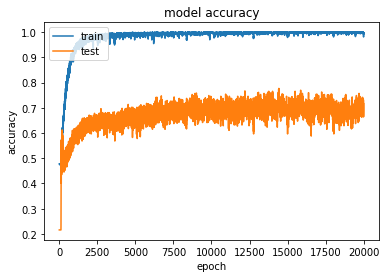

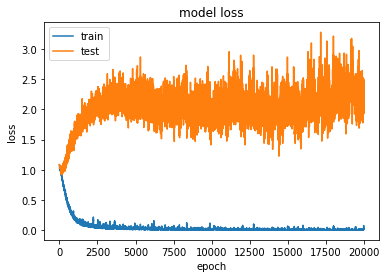

accuracy: 74.06%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


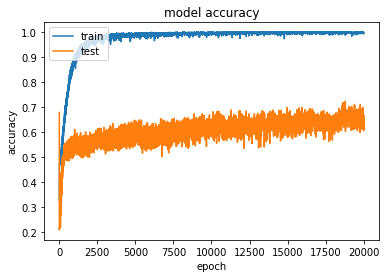

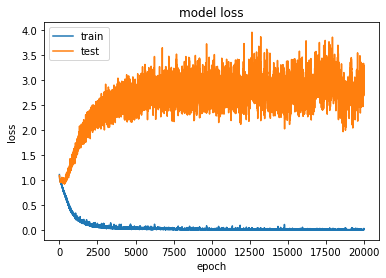

accuracy: 69.87%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


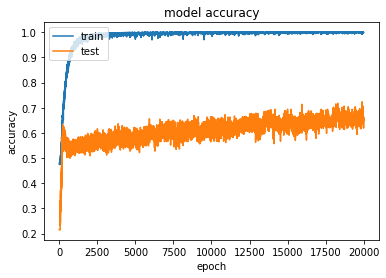

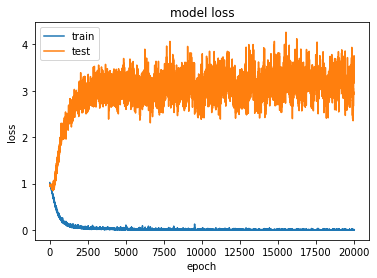

accuracy: 74.06%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


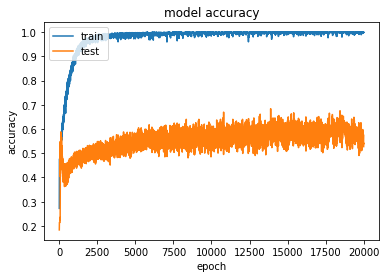

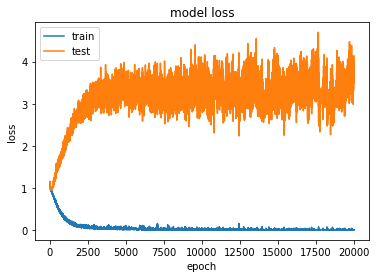

accuracy: 65.69%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


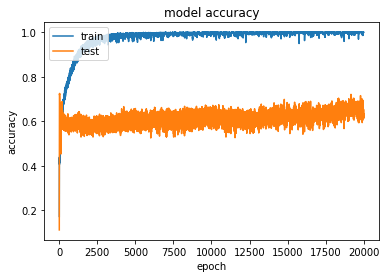

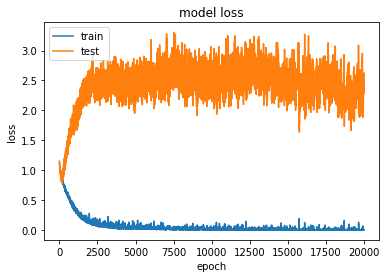

accuracy: 69.04%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


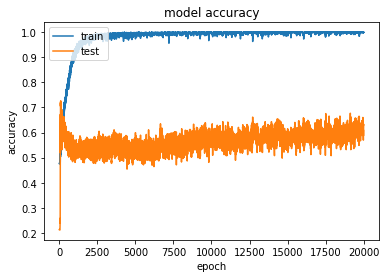

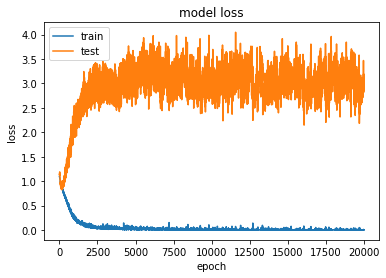

accuracy: 66.11%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


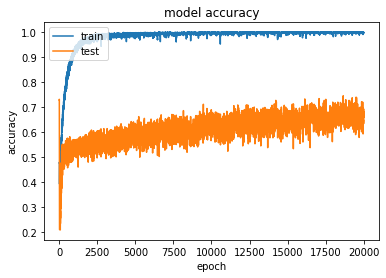

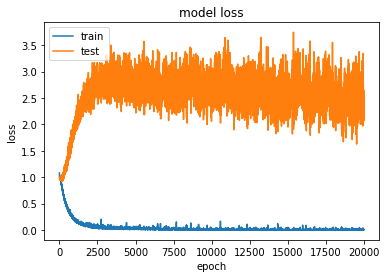

accuracy: 76.99%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


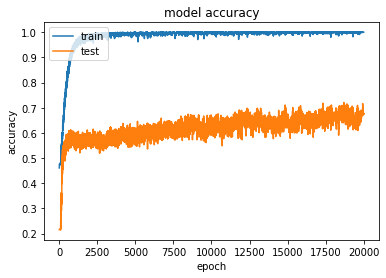

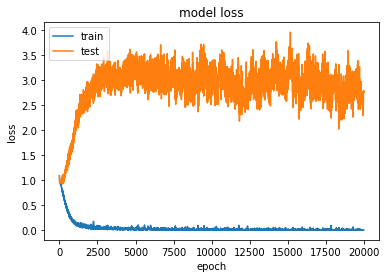

accuracy: 69.87%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


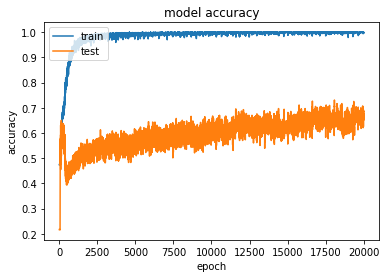

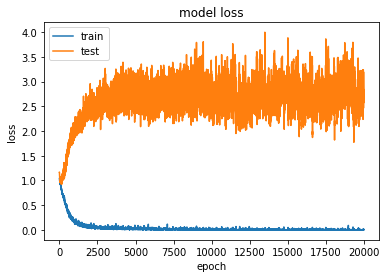

accuracy: 76.05%
started fitting
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


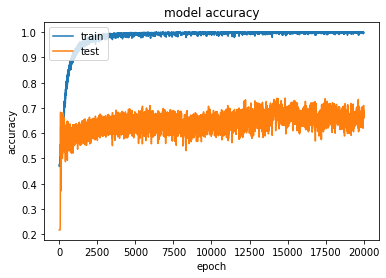

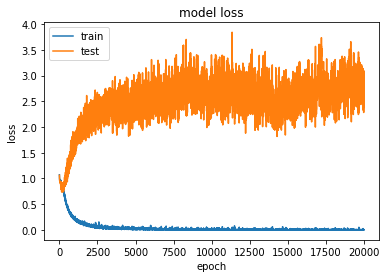

accuracy: 75.11%
71.68% (+/- 3.88%)
average time spent on fitting for each cv with epoch=  20000, batchsize=  500 is:  5934.666213 seconds


<Figure size 432x288 with 0 Axes>

In [116]:
# Load the dataset we want
X=np.load('X.npy')
y=np.load('y.npy')

y1 = np.array([yi[1:] for yi in y])

with open('y1_list.json') as infile:
    y1_list=json.load(infile)
y1_list = np.array(y1_list) - 1

# set_trace()
# Train and evalute the LSTM model using 10-fold cross-validation
folds,verbose, epochs, batch_size=10,0,20000,500
cvscores,cvtime=LSTM_cv(folds,verbose, epochs, batch_size,X,y1_list,y1)

# Print out the result to console
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("average time spent on fitting for each cv with epoch= % d, batchsize= % d is: % 8f seconds" % (epochs,batch_size,np.mean(cvtime)))

# Print out the result to txt
sample = open('results/office1and2_lstm_result.txt', 'w+') 
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)), file = sample) 
print("average time spent on fitting for each cv with epoch= % d, batchsize= % d is: % .8f seconds" % (epochs,batch_size,np.mean(cvtime)), file = sample)
sample.close() 